#Parcial #4, Metodos Computacionales#
****
**Realizado por:** Juan Sebastian Pabon Martinez

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.optimize as spo

In [207]:
url = 'https://raw.githubusercontent.com/asegura4488/Database/main/MetodosComputacionalesReforma/DataRotacion.csv'
Data = pd.read_csv(url)

In [223]:

def filter(data,angles):
  return data[data.angle == angles]

data=filter(Data,30)
data

,h,angle,y,sigmay
20,10.0,30.0,0.0013,0.0015
21,20.0,30.0,0.0017,0.0015
22,30.0,30.0,0.0038,0.0015
23,40.0,30.0,0.0059,0.0015
24,50.0,30.0,0.0067,0.0015
25,60.0,30.0,0.0094,0.0015
26,70.0,30.0,0.0122,0.0015
27,80.0,30.0,0.0132,0.0015
28,90.0,30.0,0.0151,0.0015
29,100.0,30.0,0.0186,0.0015


In [224]:
def coriolis(h,lamda,p,g):
  one= np.sqrt(2)*2*(1/3)
  two=p*np.cos(np.deg2rad(lamda))
  three= np.sqrt(h**3/g)
  y=one*two*three
  return y

In [225]:
def Chi2(p,h,y,sigmay,lambda_,g):
    return np.sum ( (y-coriolis(h,lambda_,p,g))**2/(2*sigmay**2) )


In [226]:
h=data.h
y= data.y
sigma= data.sigmay

In [227]:
p=np.ones(1)
nll = lambda *p: Chi2(*p)

resultado = spo.minimize( nll, p, args=(h,y,sigma,30,9.81),options={'disp':True} )

Optimization terminated successfully.
         Current function value: 1.145718
         Iterations: 3
         Function evaluations: 8
         Gradient evaluations: 4


In [228]:
omega= resultado.x
print("El valor mejor aproximado para omega es: {}".format(omega))

El valor mejor aproximado para omega es: [7.24399804e-05]


Text(0, 0.5, 'y')

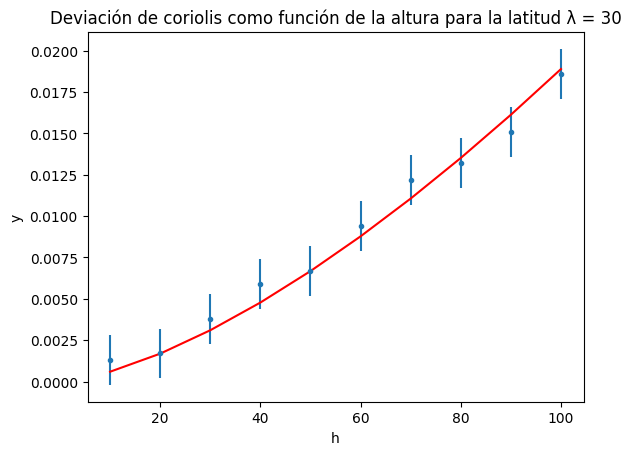

In [229]:
modelo= coriolis(h,30,omega,9.81)
plt.errorbar(h,y,sigma,fmt='.')
plt.plot(h,modelo,color='r')
plt.title('Deviación de coriolis como función de la altura para la latitud λ = 30')
plt.xlabel('h')
plt.ylabel('y')

#**Propagación de la incertidumbre de la aceleración de la gravedad:**

In [230]:
y = np.array(data.y)
h =  np.array(data.h)
sigmay = np.array(data.sigmay)

In [231]:

def Estimacion(y, h, sigmay,lambda_):
  Gravity= np.zeros(300)
  Omega=np.zeros(300)
  for i in range(300):
    G = 9.81 + np.random.normal(loc=0,scale=1)
    Gravity[i]= G
    y_modified = y + np.random.normal(loc=0,scale=sigmay[0],size=len(y))
    result_ = spo.minimize(nll,p, args=(h,y_modified,sigmay,lambda_,G),options={'disp':True})
    Omega[i]= result_.x

  return Omega,Gravity


In [189]:
def Continue_Distribution (Omega,Gravity):
  gridy = np.linspace(min(Gravity),max(Gravity),30)
  gridx = np.linspace(min(Omega),max(Omega),30)
  H2, binsx, binsy = np.histogram2d(Omega,Gravity,bins=(gridx,gridy))
  return H2, binsx, binsy 


In [232]:
Omega_30,Gravity_30= Estimacion(y, h, sigmay,30)
H2_30,binsx_30,binsy_30=Continue_Distribution(Omega_30,Gravity_30)

         Current function value: 7.906992
         Iterations: 2
         Function evaluations: 80
         Gradient evaluations: 34
         Current function value: 8.367714
         Iterations: 2
         Function evaluations: 60
         Gradient evaluations: 24
         Current function value: 4.742332
         Iterations: 2
         Function evaluations: 72
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 11.719058
         Iterations: 3
         Function evaluations: 8
         Gradient evaluations: 4
         Current function value: 4.035846
         Iterations: 2
         Function evaluations: 78
         Gradient evaluations: 33
         Current function value: 9.520064
         Iterations: 2
         Function evaluations: 60
         Gradient evaluations: 24
         Current function value: 2.889537
         Iterations: 2
         Function evaluations: 100
         Gradient evaluations: 44
         Current function value

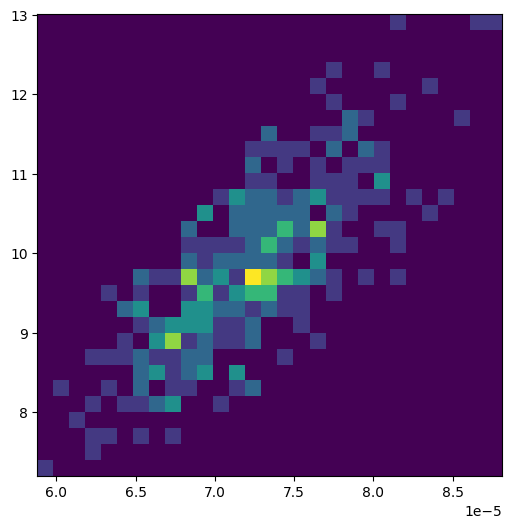

In [233]:
fig= plt.figure(figsize=(6,6))
plt.imshow(H2_30.T, origin='lower', extent=[binsx_30[0], binsx_30[-1], binsy_30[0], binsy_30[-1]], aspect='auto')

g) Son dependientes

In [234]:
#h
H1 = np.sum(H2_30,axis=1)
H1

array([ 1.,  1.,  1.,  4.,  4.,  5., 15., 12., 16., 23., 24., 13., 22.,
       31., 27., 19., 14., 20., 13.,  9.,  6.,  8.,  5.,  1.,  2.,  1.,
        1.,  1.,  1.])

In [235]:
#i
def trust_interval (H2,binsx):
  H1 = np.sum(H2,axis=1)
  cs = np.cumsum(H1)
  ij = np.searchsorted( cs, np.percentile(cs,16) )
  ii = np.searchsorted( cs, np.percentile(cs,50) )
  ji = np.searchsorted( cs, np.percentile(cs,84) )
  best_omega= binsx[ii]
  upper_limit= binsx[ji]
  lower_limit= binsx[ij]
  return best_omega,lower_limit,upper_limit

best_omega,lower_limit,upper_limit= trust_interval(H2_30,binsx_30)

print("El mejor estimados para omega en lambda= 30 es: {}".format(best_omega))
print("El intervalo de confianza al 68% para lambda = 30 es {} y {}".format(lower_limit,upper_limit))

El mejor estimados para omega en lambda= 30 es: 7.297606319131825e-05
El intervalo de confianza al 68% para lamda = 30 es 6.387136625933738e-05 y 8.309239311574145e-05


In [276]:
best_omegas=[]
errors=[]
for i in range(1,7):
  n_data=filter(Data,i*10)
  y = np.array(n_data.y)
  h =  np.array(n_data.h)
  sigmay = np.array(n_data.sigmay)
  Omega_n,Gravity_n= Estimacion(y, h, sigmay, i*10)
  H2_n,binsx_n,binsy_n=Continue_Distribution(Omega_n,Gravity_n)
  best_omega,lower_limit,upper_limit= trust_interval(H2_n,binsx_n)
  best_omegas.append(best_omega)
  errors.append(np.abs((upper_limit - lower_limit)/2))


Se han truncado las últimas 5000 líneas del flujo de salida.
Optimization terminated successfully.
         Current function value: 4.256231
         Iterations: 3
         Function evaluations: 8
         Gradient evaluations: 4
         Current function value: 3.687032
         Iterations: 2
         Function evaluations: 74
         Gradient evaluations: 31
         Current function value: 3.771973
         Iterations: 2
         Function evaluations: 54
         Gradient evaluations: 21
         Current function value: 4.947860
         Iterations: 2
         Function evaluations: 84
         Gradient evaluations: 36
         Current function value: 11.277507
         Iterations: 2
         Function evaluations: 68
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 2.020153
         Iterations: 3
         Function evaluations: 8
         Gradient evaluations: 4
         Current function value: 1.663133
         Iterations: 2
   

In [277]:
best_omegas

[6.807432919766831e-05,
 6.960868518080801e-05,
 7.324652050340304e-05,
 7.094312028129911e-05,
 6.650069319832081e-05,
 7.274796898593447e-05]

In [278]:

combined= np.mean(best_omegas)
combined

7.018688622457229e-05

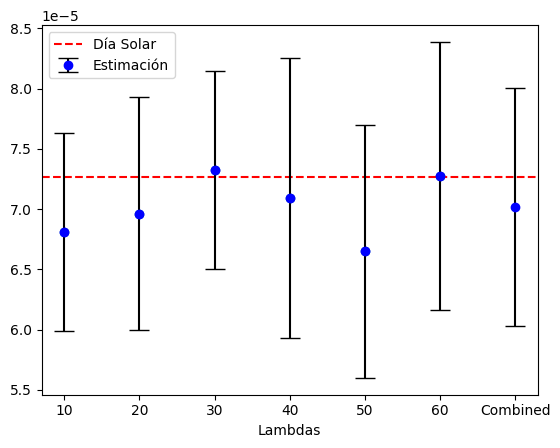

In [279]:
angles=[10,20,30,40,50,60]
plt.scatter(angles,best_omegas)
plt.axhline(7.27e-5, linestyle = 'dashed', color = 'r', label="Día Solar")
for i in range(len(best_omegas)):
  ax = plt.errorbar(angles[i], best_omegas[i], linestyle="None", yerr = errors[i], fmt="ob", capsize=7, ecolor="k")
plt.errorbar(70, combined, linestyle="None", yerr = np.sum(errors)/len(errors), fmt="ob", capsize=7, ecolor="k", label = "Estimación")
plt.xticks(angles + [70],["10", "20", "30", "40", "50", "60", "Combined"])
plt.xlabel('Lambdas')
plt.legend()